## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill
import json
import os

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from sklearn import metrics as skmetrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset, Results, Model, ModelWithAutoencoders, ModelAnalysis, EarlyStopping
import architectures

#### Load dataframe with setups

In [3]:
# setups_df = pd.read_csv("./Results/setups.csv")
# print(setups_df.shape)
# setups_df

## Train and evaluate new model

#### Load dataset

In [4]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)
print(full_dataset.full_cell_lines_data.shape, full_dataset.drugs_data.shape)

Kinases Dataset + Remaning GDSC drug's putative targets <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset.
Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
nmutations in 18 genes.
In addition, expressions and mutations (17 new features) of remaining target genes from GDSC are included
Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered.
(922, 242) (74, 294)


#### Data preprocessing

In [5]:
# Establish response data for samples (drug-cell line pairs)
response_df = full_dataset.response_data.copy()

# Establish cell line features data
cell_line_data_original_df = full_dataset.full_cell_lines_data.copy()

# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_original_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_original_df.index = cell_line_data_original_df.cell_line_id
cell_line_data_original_df = cell_line_data_original_df.drop("cell_line_id", axis=1)

# Extract response only for cell lines for which features are present
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]

# Establish drug features data
drug_data_original_df = full_dataset.drugs_data.copy()

# Convert drug index from LINCS name to GDSC drug ID
drug_data_original_df.index = drug_data_original_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)

# Establish how many cells go to train/val/test sets
num_val_cell_lines = 100
num_test_cell_lines = 100

print(drug_data_original_df.shape, cell_line_data_original_df.shape)

(74, 294) (922, 241)


In [6]:
# response_df["AUC"].describe()

In [7]:
# Establish train, validation, and test sets
split_seed = 40   # ESTABLISH SPLIT SEED
# Split data into train/val/test sets
samples_train, samples_val, samples_test, cell_lines_test, cell_lines_val = Dataset.samples_train_test_split(
                                                                        response_df,
                                                                        num_val_cell_lines,
                                                                        num_test_cell_lines,
                                                                        split_seed,
                                                                        shuffle=True)
# Merge training and validation samples
samples_train_and_val = pd.concat([samples_train, samples_val], axis=0)
                                                                       
# Normalize the data
# Cell line data
cols_subset = [col for col in list(cell_line_data_original_df) if col.endswith("_exp")]
rows_subset = [x for x in cell_line_data_original_df.index if x not in cell_lines_test + cell_lines_val]

cell_line_data_df = Dataset.standardize_data(cell_line_data_original_df, cols_subset=cols_subset,
                                            rows_subset=rows_subset)
# Drug data
drug_data_df = Dataset.standardize_data(drug_data_original_df)

#### Exclude drugs if needed

In [8]:
# drugs_to_exclude = [110, 1038, 1158, 1614, 1632, 54, 59, 1052, 253]
# print(len(drugs_to_exclude))
# print(samples_train["DRUG_ID"].nunique(), samples_val["DRUG_ID"].nunique(),
#      samples_train_and_val["DRUG_ID"].nunique(), samples_test["DRUG_ID"].nunique())
# samples_train = Dataset.exclude_drugs(samples_train, drugs_to_exclude)
# samples_val = Dataset.exclude_drugs(samples_val, drugs_to_exclude)
# samples_train_and_val = Dataset.exclude_drugs(samples_train_and_val, drugs_to_exclude)
# samples_test = Dataset.exclude_drugs(samples_test, drugs_to_exclude)

# print(samples_train["DRUG_ID"].nunique(), samples_val["DRUG_ID"].nunique(),
#      samples_train_and_val["DRUG_ID"].nunique(), samples_test["DRUG_ID"].nunique())

#### Definition of new PyTorch network if needed

#### Instantiate the new system

In [136]:
state_dict = None
torch.manual_seed(11)
def establish_new_system(drug_dim, cell_line_dim, code_dim, architecture_type,
                    num_layers, drug_hidden_dim1, drug_hidden_dim2, drug_hidden_dim3,
                    cell_line_hidden_dim1, cell_line_hidden_dim2, cell_line_hidden_dim3,
                     dropout, dropout_rate, code_activation, activation_func, out_activation,
                        batch_norm):
    # Establish specs
    specs = {"drug_dim": drug_dim,
            "cell_line_dim": cell_line_dim,
            "code_dim": code_dim,
            "architecture_type": architecture_type,
            "num_layers": num_layers,
            "drug_hidden_dim1": drug_hidden_dim1,
            "drug_hidden_dim2": drug_hidden_dim2,
            "drug_hidden_dim3": drug_hidden_dim3,
            "cell_line_hidden_dim1": cell_line_hidden_dim1,
            "cell_line_hidden_dim2": cell_line_hidden_dim2,
            "cell_line_hidden_dim3": cell_line_hidden_dim3,
            "dropout": dropout,
            "dropout_rate": dropout_rate,
            "code_activation": code_activation,
            "activation_func": activation_func,
            "out_activation": out_activation,
            "batch_norm": batch_norm}
    
    
    network = ModelAnalysis.instantiate_system(specs, state_dict)
    return network

establish_new_system_widget = interactive(establish_new_system,
                                     drug_dim=[294],
                                     cell_line_dim=[241, 1144],
                                     code_dim=widgets.IntSlider(value=10, min=2, max=30),
                                     architecture_type=["autoencoders", "linear"],
                                     num_layers=[1, 2, 3, None],
                                     drug_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     drug_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     drug_hidden_dim3=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim3=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     dropout=[False, True],
                                     dropout_rate=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05),
                                     code_activation=[False, True],
                                     activation_func=[nn.ReLU, nn.Tanh, nn.SELU],
                                     out_activation=[torch.sigmoid, None],
                                     batch_norm=[False, True])
display(establish_new_system_widget)

interactive(children=(Dropdown(description='drug_dim', options=(294,), value=294), Dropdown(description='cell_…

In [137]:
# MUST EXECUTE ALSO
network = establish_new_system_widget.result
print(network.out_activation)
print(next(network.parameters()).sum())
network

<built-in method sigmoid of type object at 0x7fd2a6488640>
tensor(4.2539, grad_fn=<SumBackward0>)


RecSystemWithAutoencoders(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=241,

#### Add code forwarding if needed

In [ ]:
# Modify network to add forward propagation of codes if needed
def forward_network_specs(model_type, num_layers, code_interactions, code_dim,
                         out_activation, forward_net_hidden_dim1,
                         forward_net_hidden_dim2, drop_rate):
    if model_type == "linear":
        if code_interactions:
            m = architectures.ForwardLinearRegression(code_dim ** 2 + 2 * code_dim, 
                                            out_activation=out_activation)
        else:
            m = architectures.ForwardLinearRegression(2 * code_dim, 
                                                      out_activation=out_activation)
    else:
        if code_interactions:
            if num_layers == 1:
                m = architectures.ForwardNetworkOneHiddenLayer(code_dim ** 2 + 2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
            elif num_layers == 2:
                m = architectures.ForwardNetworkTwoHiddenLayers(code_dim ** 2 + 2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          forward_net_hidden_dim2,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
        else:
            if num_layers == 1:
                m = architectures.ForwardNetworkOneHiddenLayer(2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
            elif num_layers == 2:
                m = architectures.ForwardNetworkTwoHiddenLayers(2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          forward_net_hidden_dim2,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
    return m, code_interactions

forward_net_specs_widget = interactive(forward_network_specs,
                                       model_type=["linear", "nn"],
                                       num_layers=[1, 2, 3],
                                       code_interactions=[False, True],
                                       code_dim=widgets.IntSlider(value=10, min=2, max=30),
                                       out_activation=[None, torch.sigmoid],
                                       forward_net_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                       forward_net_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                       drop_rate=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05))
                                       
display(forward_net_specs_widget)

#### Pre-train autoencoders

In [139]:
print(next(network.drug_autoencoder.parameters()).sum())
print(next(network.cell_line_autoencoder.parameters()).sum())
drug_autoencoder = network.drug_autoencoder
cell_line_autoencoder = network.cell_line_autoencoder
print(next(drug_autoencoder.parameters()).sum())
print(next(cell_line_autoencoder.parameters()).sum())

tensor(4.2539, grad_fn=<SumBackward0>)
tensor(-13.2661, grad_fn=<SumBackward0>)
tensor(4.2539, grad_fn=<SumBackward0>)
tensor(-13.2661, grad_fn=<SumBackward0>)


In [ ]:
# Batch training for drug autencoder
learning_rate = 0.001
num_epochs = 100
optimizer = torch.optim.Adam(drug_autoencoder.parameters(), lr=learning_rate)
reconstruction_criterion = nn.MSELoss()

for epoch in range(1, num_epochs + 1):
    drug_autoencoder.train()
    drug_input = torch.from_numpy(drug_data_df.values)
    drug_codes, drug_reconstruction = drug_autoencoder(drug_input.float())
    loss = reconstruction_criterion(drug_reconstruction, drug_input.float())
    optimizer.zero_grad()
    # Get the gradients w.r.t. the parameters
    loss.backward()
    # Update the parameters
    optimizer.step()
    
    print("Epoch: {}, loss: {}".format(epoch, loss.item()))

print(drug_input.shape, drug_reconstruction.shape)
print("Whole correlation:", pearsonr(drug_input.numpy().flatten(),
                  drug_reconstruction.detach().numpy().flatten()))
# Per drug corr
corrs = []
for i in range(drug_input.shape[0]):
    drug_original = drug_input[i]
    drug_rec = drug_reconstruction[i]
    corrs.append(pearsonr(drug_original.numpy(), drug_rec.detach().numpy())[0])
print("Median corr per drug:", np.median(corrs))

In [ ]:
# Batch training for cell line autencoder
learning_rate = 0.001
num_epochs = 100
optimizer = torch.optim.Adam(cell_line_autoencoder.parameters(), lr=learning_rate)

cell_lines_train = list(set(cell_line_data_original_df.index) - set(cell_lines_test) - set(cell_lines_val))
cl_input_df = cell_line_data_df.loc[cell_lines_train]

for epoch in range(1, num_epochs + 1):
    cell_line_autoencoder.train()
    cl_input = torch.from_numpy(cl_input_df.values)
    cl_codes, cl_reconstruction = cell_line_autoencoder(cl_input.float())
    loss = reconstruction_criterion(cl_reconstruction, cl_input.float())
    optimizer.zero_grad()
    # Get the gradients w.r.t. the parameters
    loss.backward()
    # Update the parameters
    optimizer.step()
    
    print("Epoch: {}, loss: {}".format(epoch, loss.item()))
    
print(cl_input.shape, cl_reconstruction.shape)
print("Whole correlation:", pearsonr(cl_input.numpy().flatten(),
                  cl_reconstruction.detach().numpy().flatten()))
# Per drug corr
corrs = []
for i in range(cl_input.shape[0]):
    cl_original = cl_input[i]
    cl_rec = cl_reconstruction[i]
    corrs.append(pearsonr(cl_original.numpy(), cl_rec.detach().numpy())[0])
print("Median corr per cell line:", np.median(corrs))

In [94]:
print(next(network.drug_autoencoder.parameters()).sum())
print(next(network.cell_line_autoencoder.parameters()).sum())

print(next(drug_autoencoder.parameters()).sum())
print(next(cell_line_autoencoder.parameters()).sum())

tensor(-35.8564, grad_fn=<SumBackward0>)
tensor(81.2122, grad_fn=<SumBackward0>)
tensor(-35.8564, grad_fn=<SumBackward0>)
tensor(81.2122, grad_fn=<SumBackward0>)


#### Train

In [140]:
# Training params
num_epochs = 100
batch_size = 256
no_batches = samples_train.shape[0] // batch_size + 1
# Establish the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.00005
reconstruction_term_drug = 0.0
reconstruction_term_cl = 0.
independence_term_drug = 0.
independence_term_cl = 0.
reg_lambda = 0.0

augment_data = False

if augment_data:
    balanced_augmentation = True
    if balanced_augmentation:
        auc_threshold = 0.85
    augmented_data_factor = 2
    cell_line_exp_idx = 202
    cell_line_noise_mean = 0.0
    cell_line_noise_std = 0.6
    target_variable_noise_mean = 0.
    target_variable_noise_std = 0.15


optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

weigh_by_true_auc = False
if weigh_by_true_auc:
    output_criterion = nn.MSELoss(reduction="none")
else:
    output_criterion = nn.MSELoss()
    
reconstruction_criterion = nn.MSELoss()

print(no_batches, device)

161 cpu


In [141]:
early_stopping = EarlyStopping(patience=num_epochs, delta=0.000)

In [142]:
# Establish train samples
train_samples = samples_train.copy()
print(train_samples.shape)

np.random.seed(11)

# model = ModelWithAutoencoders("Test", network)
train_losses = []
train_y_losses = []
drug_independence_train_losses = []
cl_independence_train_losses = []
train_rmses = []
train_corrs = []
train_median_corrs = []
train_drug_rec_corrs = []
train_cl_rec_corrs = []
val_rmses = []
val_corrs = []
val_median_corrs = []
val_drug_rec_corrs = []
val_cl_rec_corrs = []

# Establish the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Move the network into device
network.to(device)
# Training the model
network.train()

for epoch in range(1, num_epochs + 1):
    # train_samples = train_samples.sample(frac=1., random_state = 11)
    # Initialize lists for storing training losses during batches
    epoch_main_losses = 0
    epoch_y_losses = 0
    epoch_drug_indep_losses = 0
    epoch_cl_indep_losses = 0
    for batch in range(no_batches):
        # Separate response variable batch
        if batch != no_batches:
            samples_batch = train_samples.iloc[batch * batch_size:(batch + 1) * batch_size]
        else:
            samples_batch = train_samples.iloc[batch * batch_size:]

        # Extract output variable batch
        y_batch = samples_batch["AUC"].values.reshape(-1, 1)
        
        # Extract cell lines IDs for which data shall be extracted
        cl_ids = samples_batch["COSMIC_ID"].values
        # Extract corresponding cell line data
        cell_line_input_batch = cell_line_data_df.loc[cl_ids].values

        # Extract drug IDs for which data shall be extracted
        drug_ids = samples_batch["DRUG_ID"].values
        # Extract corresponding drug data
        drug_input_batch = drug_data_df.loc[drug_ids].values
        
        # Augment data if specified
        if augment_data:
            original_drug_batch = drug_input_batch.copy()
            original_cell_line_batch = cell_line_input_batch.copy()
            original_y_batch = y_batch.copy()
            
            if balanced_augmentation:
                indexes = (original_y_batch < auc_threshold).reshape(-1)
                
                original_drug_batch = original_drug_batch[indexes, :]
                original_cell_line_batch = original_cell_line_batch[indexes, :]
                original_y_batch = original_y_batch[indexes, :]

            for i in range(augmented_data_factor):
                augmented_cell_line_data = original_cell_line_batch[:, :cell_line_exp_idx]
                cell_line_noise = np.random.normal(loc=cell_line_noise_mean,
                                                  scale=cell_line_noise_std,
                                                  size=augmented_cell_line_data.shape)
                augmented_cell_line_data = augmented_cell_line_data + cell_line_noise
                augmented_cell_line_data = np.concatenate((augmented_cell_line_data, 
                                                           original_cell_line_batch[:, cell_line_exp_idx:]),
                                                          axis=1)
                augmented_response_data = original_y_batch + np.random.normal(loc=target_variable_noise_mean,
                                                            scale=target_variable_noise_std,
                                                            size=original_y_batch.shape)
                cell_line_input_batch = np.concatenate((cell_line_input_batch, augmented_cell_line_data),
                                                      axis=0)
                y_batch = np.concatenate((y_batch, augmented_response_data), axis=0)
                drug_input_batch = np.concatenate((drug_input_batch, original_drug_batch), axis=0)
                

        # Clear gradient buffers because we don't want to accummulate gradients 
        optimizer.zero_grad()
        
        # Put data batches into torch and device
        cell_line_input_batch = torch.from_numpy(cell_line_input_batch).to(device)
        drug_input_batch = torch.from_numpy(drug_input_batch).to(device)
        y_batch = torch.from_numpy(y_batch).to(device)

        # Perform forward pass
        batch_output, batch_drug_reconstruction, batch_cl_reconstruction = network(
            drug_input_batch.float(), cell_line_input_batch.float())

        # L2 regularization
        reg_sum = 0
        for param in network.parameters():
            reg_sum += 0.5 * (param ** 2).sum()  # L2 norm

        # Compute the loss for this batch, including the drug and cell line reconstruction losses
        # Variant wit weightning the samples
        if weigh_by_true_auc:
            output_loss = output_criterion(batch_output, y_batch.float())
            output_loss = torch.mul(output_loss, y_batch.float() ** 0.5)
            output_loss = output_loss.mean() + reg_lambda * reg_sum
        # Variant with normal loss
        else:
            output_loss = output_criterion(batch_output, y_batch.float()) + reg_lambda * reg_sum
        # Reconstruction losses
        drug_recounstruction_loss = reconstruction_criterion(batch_drug_reconstruction, drug_input_batch.float())
        cl_reconstruction_loss = reconstruction_criterion(batch_cl_reconstruction, cell_line_input_batch.float())

        # Compute independence loss
        # Covariance matrices
        drug_codes_batch = network.drug_autoencoder.encoder(drug_input_batch.float())
        cl_codes_batch = network.cell_line_autoencoder.encoder(cell_line_input_batch.float())
        drug_cov = ModelWithAutoencoders.covariance_matrix_torch(drug_codes_batch)
        cl_cov = ModelWithAutoencoders.covariance_matrix_torch(cl_codes_batch)
        
        # Actual dependence losses
        drug_independence_loss = (drug_cov * drug_cov).sum() - torch.trace(drug_cov * drug_cov)
        cl_independence_loss = (cl_cov * cl_cov).sum() - torch.trace(cl_cov * cl_cov)

        # Combine the losses in the final cost function
        loss = output_loss + reconstruction_term_drug * drug_recounstruction_loss + \
                reconstruction_term_cl * cl_reconstruction_loss + \
                independence_term_drug * drug_independence_loss + independence_term_cl * cl_independence_loss
        
        # Get the gradients w.r.t. the parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        epoch_main_losses += loss.item()
        epoch_y_losses += output_loss.item()
        epoch_drug_indep_losses += drug_independence_loss.item()
        epoch_cl_indep_losses += cl_independence_loss.item()
    
    f = lambda x: np.round(x, 3)
    print("Epoch: {}, main loss: {}, output loss: {} drug independence loss: {}, cell line independence loss: {}".format(
        epoch, f(epoch_main_losses / no_batches), f(epoch_y_losses / no_batches),
        f(epoch_drug_indep_losses / no_batches), f(epoch_cl_indep_losses / no_batches)))
    
    # Update metrics for learning curve
    train_losses.append(epoch_main_losses / no_batches)
    train_y_losses.append(epoch_y_losses / no_batches)
    drug_independence_train_losses.append(epoch_drug_indep_losses / no_batches)
    cl_independence_train_losses.append(epoch_cl_indep_losses / no_batches)
    
    # Evaluate on training data
    model = ModelWithAutoencoders("Example", network)
    predicted, y_true, drug_input, cl_input = model.predict(train_samples, cell_line_data_df, drug_data_df)
    preds, drug_reconstruction, cl_reconstruction = predicted
    try:
        train_rmse, train_corr = Model.evaluate_predictions(y_true, preds.cpu().numpy().reshape(-1))
    except ValueError:
        train_rmse, train_corr = np.nan, (np.nan, np.nan)
    # Drug reconstruction training error
    try:
        train_drug_rec_rmse, train_drug_rec_corr = Model.evaluate_predictions(drug_input.flatten(),
                                        drug_reconstruction.cpu().numpy().flatten())
    except ValueError:
        train_drug_rec_rmse, train_drug_rec_corr = np.nan, (np.nan, np.nan)

    # Cell line reconstruction training error
    try:
        train_cl_rec_rmse, train_cl_rec_corr = Model.evaluate_predictions(cl_input.flatten(),
                                        cl_reconstruction.cpu().numpy().flatten())
    except ValueError:
        train_cl_rec_rmse, train_cl_rec_corr = np.nan, (np.nan, np.nan)

    performance_df = Model.per_drug_performance_df(train_samples, preds.cpu())
    train_median_rmse = performance_df["Model RMSE"].median()
    train_median_corr = performance_df["Model correlation"].median()
    
    train_rmses.append(train_rmse)
    train_corrs.append(train_corr[0])
    train_median_corrs.append(train_median_corr)
    train_drug_rec_corrs.append(train_drug_rec_corr[0])
    train_cl_rec_corrs.append(train_cl_rec_corr[0])
    
    # Evaluate on validation data
    predicted, y_true, drug_input, cl_input = model.predict(samples_val, cell_line_data_df, drug_data_df)
    preds, drug_reconstruction, cl_reconstruction = predicted
    
    # Main validation error
    try:
        val_rmse, val_corr = Model.evaluate_predictions(y_true, preds.cpu().numpy().reshape(-1))
    except ValueError:
        val_rmse, val_corr = np.nan, (np.nan, np.nan)

    # Drug reconstruction validation error
    try:
        val_drug_rec_rmse, val_drug_rec_corr = Model.evaluate_predictions(drug_input.flatten(),
                                        drug_reconstruction.cpu().numpy().flatten())
    except ValueError:
        val_drug_rec_rmse, val_drug_rec_corr = np.nan, (np.nan, np.nan)

    # Cell line reconstruction validation error
    try:
        val_cl_rec_rmse, val_cl_rec_corr = Model.evaluate_predictions(cl_input.flatten(),
                                        cl_reconstruction.cpu().numpy().flatten())
    except ValueError:
        val_cl_rec_rmse, val_cl_rec_corr = np.nan, (np.nan, np.nan)
    # Per-drug validation evaluation
    performance_df = Model.per_drug_performance_df(samples_val, preds.cpu())
    val_median_corr = performance_df["Model correlation"].median()
        
    val_rmses.append(val_rmse)
    val_corrs.append(val_corr[0])
    val_drug_rec_corrs.append(val_drug_rec_corr[0])
    val_cl_rec_corrs.append(val_cl_rec_corr[0])
    val_median_corrs.append(val_median_corr)
    
    early_stopping(val_rmse, network)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

(41130, 3)
cpu
Epoch: 1, main loss: 0.12, output loss: 0.12 drug independence loss: 9.489, cell line independence loss: 0.004


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Epoch: 2, main loss: 0.041, output loss: 0.041 drug independence loss: 78.868, cell line independence loss: 0.023
Epoch: 3, main loss: 0.027, output loss: 0.027 drug independence loss: 27.772, cell line independence loss: 0.056
Epoch: 4, main loss: 0.021, output loss: 0.021 drug independence loss: 16.509, cell line independence loss: 0.12
Epoch: 5, main loss: 0.018, output loss: 0.018 drug independence loss: 13.462, cell line independence loss: 0.191
Epoch: 6, main loss: 0.017, output loss: 0.017 drug independence loss: 11.374, cell line independence loss: 0.252
Epoch: 7, main loss: 0.016, output loss: 0.016 drug independence loss: 9.998, cell line independence loss: 0.285
Epoch: 8, main loss: 0.016, output loss: 0.016 drug independence loss: 9.211, cell line independence loss: 0.302
Epoch: 9, main loss: 0.015, output loss: 0.015 drug independence loss: 8.836, cell line independence loss: 0.313
Epoch: 10, main loss: 0.015, output loss: 0.015 drug independence loss: 8.567, cell line ind

In [143]:
cell_line_input_batch.shape

torch.Size([170, 241])

In [144]:
def learning_curve(metric1, metric2):
    """Plot learning curve related to a given metric."""
    dic = {"Whole training loss": train_losses,
           "Y loss": train_y_losses,
          "Drug independence train loss": drug_independence_train_losses,
          "Cl independence train loss": cl_independence_train_losses,
           "Train RMSE": train_rmses,
           "Train corr.": train_corrs,
           "Train median corr.": train_median_corrs,
           "Train drug rec corr.": train_drug_rec_corrs,
           "Train cl rec corr.": train_cl_rec_corrs,
          "Val RMSE": val_rmses,
          "Val corr.": val_corrs,
          "Val median corr.": val_median_corrs,
          "Val drug rec corr.": val_drug_rec_corrs,
          "Val cl rec corr.": val_cl_rec_corrs}
    
    x = range(1, len(train_losses) + 1)
    print("Max {}: {}".format(metric1, max(dic[metric1])))
    sns.lineplot(x, dic[metric1], label=metric1)
    if metric2:
        print("Max {}: {}".format(metric2, max(dic[metric2])))
        sns.lineplot(x, dic[metric2], label=metric2)
    
    plt.grid()
    plt.show()
    
metrics = ["Whole training loss", "Y loss", "Drug independence train loss", "Cl independence train loss",
           "Train RMSE", "Train corr.", "Train median corr.", "Train drug rec corr.", "Train cl rec corr.",
          "Val RMSE", "Val corr.", "Val median corr.", "Val drug rec corr.", "Val cl rec corr."]

interact(learning_curve,
        metric1=metrics,
        metric2=[None] + metrics)

interactive(children=(Dropdown(description='metric1', options=('Whole training loss', 'Y loss', 'Drug independ…

<function __main__.learning_curve(metric1, metric2)>

### Evaluate response predictions

In [160]:
# Evaluation on training set
samples = samples_train.copy()
print("Training data")
print()
# Make predictions
# Linear model case
if model.__class__ == Model:
    response_preds, y_true = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    print(response_preds.shape, y_true.shape)
# Model with autoencoders case
elif model.__class__ == ModelWithAutoencoders:
    predicted, y_true, drug_input, cl_input = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    response_preds, drug_rec_preds, cl_rec_preds = predicted
    print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_train_df = samples.copy()
samples_with_predictions_train_df.insert(3, "Predicted AUC", response_preds.reshape(-1))
print(samples_with_predictions_train_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.numpy().reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

per_drug_performance_train_df = Model.per_drug_performance_df(samples, response_preds)
print(per_drug_performance_train_df.shape)
per_drug_performance_train_df.insert(1, "Drug name", per_drug_performance_train_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_train_df.shape)
per_drug_performance_train_df = per_drug_performance_train_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_train_df["Model RMSE"].median(),
     per_drug_performance_train_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.numpy().ravel())
print("Reconstruction performance:")
print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.numpy().ravel())
print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_train_df.head(2)

Training data

torch.Size([41130, 1]) (41130,) (41130, 294) (41130, 241)
(41130, 4)
Response prediction performance:
RMSE: 0.25055437547662135, Corr.: (0.19209864772865912, 0.0)


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(74, 6)
(74, 7)
Per drug median RMSE and correlation: 0.19390764997850948 -0.0016913842947118072

Reconstruction performance:
Whole drug data RMSE and correlation: 0.09 (0.9958161875150532, 0.0)
Whole cell line data RMSE and correlation: 0.582 (0.773814809710531, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
12,301,PHA-793887,0.265236,0.514778,0.196658,NaN,675
59,1180,Dinaciclib,0.424048,0.333998,0.141795,NaN,534


In [15]:
samples_with_predictions_train_df["Predicted AUC"].describe()

count    41130.000000
mean         0.836292
std          0.148480
min          0.067351
25%          0.774896
50%          0.882180
75%          0.943695
max          0.999334
Name: Predicted AUC, dtype: float64

In [27]:
# Evaluation on validation set
samples = samples_val.copy()
print("Validation data")
print()
# Make predictions
# Linear model case
if model.__class__ == Model:
    response_preds, y_true = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    print(response_preds.shape, y_true.shape)
# Model with autoencoders case
elif model.__class__ == ModelWithAutoencoders:
    predicted, y_true, drug_input, cl_input = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    response_preds, drug_rec_preds, cl_rec_preds = predicted
    print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_val_df = samples.copy()
samples_with_predictions_val_df.insert(3, "Predicted AUC", response_preds.reshape(-1))
print(samples_with_predictions_val_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.numpy().reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

per_drug_performance_val_df = Model.per_drug_performance_df(samples, response_preds)
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df.insert(1, "Drug name", per_drug_performance_val_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df = per_drug_performance_val_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_val_df["Model RMSE"].median(),
     per_drug_performance_val_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.numpy().ravel())
print("Reconstruction performance:")
print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.numpy().ravel())
print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_val_df.head(2)

Validation data

torch.Size([5840, 1]) (5840,) (5840, 294) (5840, 241)
(5840, 4)
Response prediction performance:
RMSE: 0.13658220180245545, Corr.: (0.6990380618816323, 0.0)


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(74, 6)
(74, 7)
Per drug median RMSE and correlation: 0.12456923393181013 0.23430572826913876

Reconstruction performance:
Whole drug data RMSE and correlation: 0.633 (0.767089807963461, 0.0)
Whole cell line data RMSE and correlation: 0.839 (0.49735078088668583, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
30,257,NPK76-II-72-1,0.134728,0.652238,0.176002,NaN,92
61,222,BX-912,0.166679,0.632740,0.207612,NaN,91


In [194]:
samples_with_predictions_val_df["Predicted AUC"].describe()

count    5840.000000
mean        0.838942
std         0.162643
min         0.019469
25%         0.777988
50%         0.893548
75%         0.953708
max         0.999862
Name: Predicted AUC, dtype: float64

In [195]:
np.percentile(samples_with_predictions_val_df["Predicted AUC"], 85)

0.9718583911657334

## Investigate weights and predictions

### Compute reconstructions and code embeddings for drugs and cell lines

In [28]:
# Compute reconstructions for drug
drug_codes, drug_recs = network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
print(drug_codes.shape, drug_recs.shape)
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
print(drug_codes_df.shape)
drug_codes_df.head(2)

torch.Size([74, 10]) torch.Size([74, 294])
(74, 10)


,0,1,2,3,4,5,6,7,8,9
Small Molecule,,,,,,,,,,
1242,0.089574,0.291691,-0.146056,-0.067876,0.633762,0.225896,0.374449,0.603519,0.149778,-0.003032
86,2.392476,-2.272114,0.535734,0.358482,1.128065,-0.709664,2.609271,-0.318075,1.021733,-0.067730


In [29]:
# Per-drug reconstruction performance
drug_rec_performance_df = ModelAnalysis.per_object_reconstruction_evaluations(drug_data_df,
                                                                             drug_recs)
print(drug_rec_performance_df.shape, drug_rec_performance_df["Correlation"].median())
drug_rec_performance_df.head(3)

(74, 4) 0.5827564855656515


,Object ID,Correlation,Corr. pval,RMSE
0,1242,0.371492,4.717861e-11,0.746878
1,86,0.767872,2.026013e-58,0.980261
2,29,0.737679,9.657969e-52,0.735657


In [30]:
# Compute reconstructions for cell lines
cl_codes, cl_recs = network.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
print(cl_codes.shape, cl_recs.shape)
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
print(cl_codes_df.shape)
cl_codes_df.head(2)

torch.Size([922, 10]) torch.Size([922, 241])
(922, 10)


,0,1,2,3,4,5,6,7,8,9
cell_line_id,,,,,,,,,,
906826,1.392823,-0.081070,0.369389,-0.527499,0.939603,0.435033,-0.881577,0.574289,-0.498814,-0.321765
687983,0.527475,-0.118953,1.201609,-0.741990,0.485053,0.835763,-0.358168,0.845020,0.962573,0.120482


In [31]:
# Per-cell line recosntruction performance
cl_rec_performance_df = ModelAnalysis.per_object_reconstruction_evaluations(cell_line_data_df,
                                                                             cl_recs)
print(cl_rec_performance_df.shape, cl_rec_performance_df["Correlation"].median())
cl_rec_performance_df.head(3)

(922, 4) 0.5148289229820469


,Object ID,Correlation,Corr. pval,RMSE
0,906826,0.427953,3.754734e-12,0.733828
1,687983,0.360189,8.564329e-09,0.818887
2,910927,0.403212,7.756044e-11,0.873424


In [40]:
response_df.shape

(52730, 3)

#### Covariance matrices of drug and cell lines code embeddings

torch.Size([74, 10]) torch.Size([922, 10])
(10, 10) (10, 10)


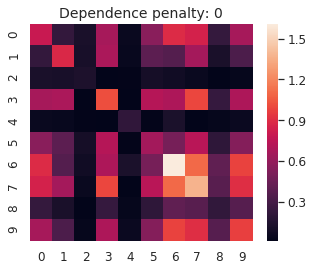

In [38]:
# Compute covariance matrices for drug and cell lines code representations
print(drug_codes.shape, cl_codes.shape)
drug_codes_cov = np.cov(drug_codes.detach().numpy(), rowvar=False)
cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
print(drug_codes_cov.shape, cl_codes_cov.shape)

# Visualize drug representations covariance matrix
sns.set(font_scale=1.1)
plt.figure(figsize=(5, 4))
ax = sns.heatmap(np.abs(drug_codes_cov), annot=False)
ax.tick_params(labelsize=12)

plt.title("Dependence penalty: 0", fontsize=14)

plt.savefig("cov_matrix_drugs_exp_1_no_penalty.pdf")
plt.show()

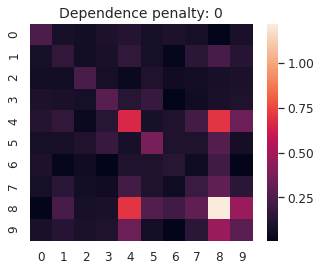

In [39]:
# Visualize cell line representations covariance matrix
sns.set(font_scale=1.1)
plt.figure(figsize=(5, 4))
ax = sns.heatmap(np.abs(cl_codes_cov), annot=False)
ax.tick_params(labelsize=12)

plt.title("Dependence penalty: 0", fontsize=14)

plt.savefig("cov_matrix_cl_exp_1_no_penalty.pdf")
plt.show()
plt.show()

### Visualize code embeddings in 2D

(74, 3)


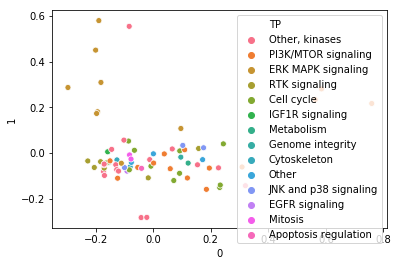

In [146]:
# Visualize drug code representations with PCA
pca = PCA(n_components=2)
codes_embedded = pca.fit_transform(drug_codes.detach().numpy())
# Create a DataFrame with drugs and their 2D embeddings
drug_embeddings_df = pd.DataFrame(codes_embedded, index=drug_codes_df.index)
drug_embeddings_df["TP"] = drug_embeddings_df.index.map(full_dataset.drug_gdsc_id_to_target_pathway_mapper)
print(drug_embeddings_df.shape)
# Visualize in 2D
sns.scatterplot(x=0, y=1, data=drug_embeddings_df, hue="TP")

plt.show()

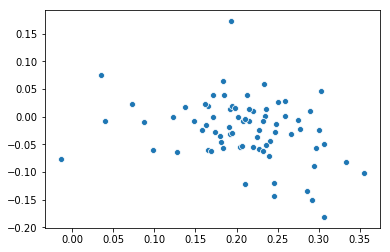

In [147]:
sns.scatterplot(drug_codes.detach().numpy()[:, 6], drug_codes.detach().numpy()[:, 9])

plt.show()

(922, 2)


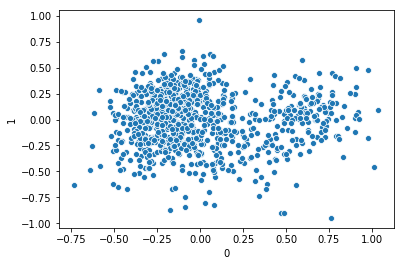

In [148]:
# Visualize cell lines code representations with PCA
pca = PCA(n_components=2)
codes_embedded = pca.fit_transform(cl_codes.detach().numpy())
# Create a DataFrame with drugs and their 2D embeddings
cl_embeddings_df = pd.DataFrame(codes_embedded, index=cl_codes_df.index)
print(cl_embeddings_df.shape)
# Visualize in 2D
sns.scatterplot(x=0, y=1, data=cl_embeddings_df)

plt.show()

### Relationship between code dimensions and input features (Neuron Attributions)

#### For drugs

In [295]:
def net(drug_input):
    return model.network.drug_autoencoder(drug_input)[0]

k = 10  # How many samples use to compute importances
drug_input = torch.from_numpy(drug_data_df.values).float()[:k]
drug_input.requires_grad_()

# Integrated Gradients
ig = IntegratedGradients(net)

drug_code_attributions, delta = ig.attribute(drug_input, target=9,  return_convergence_delta=True)
drug_code_attributions = drug_code_attributions.detach().numpy()
drug_code_attributions = np.mean(drug_code_attributions, axis=0)

# Compute drug code attributions for every dimension in code space
drug_code_attributions_df = pd.DataFrame()
for dim in range(model.network.drug_autoencoder(drug_input[0])[0].shape[0]):
    code_attributions, delta = ig.attribute(drug_input, target=dim,  return_convergence_delta=True)
    code_attributions = code_attributions.detach().numpy()
    code_attributions = np.mean(code_attributions, axis=0)
    
    drug_code_attributions_df[dim] = code_attributions
drug_code_attributions_df.index = drug_data_df.columns
print(drug_code_attributions_df.shape)
drug_code_attributions_df.head()

(294, 10)


,0,1,2,3,4,5,6,7,8,9
Protein,,,,,,,,,,
MAPKAPK2,0.001994,0.000606,0.001970,0.000224,0.004962,-0.001620,-0.000031,-0.002595,0.003721,0.000004
MARK1,0.003351,0.005488,0.000111,-0.008058,0.004211,-0.004074,0.000512,0.004947,0.010757,-0.003333
CAMKK2,0.002339,0.000065,0.000894,-0.000674,0.000734,-0.001701,0.003619,0.001217,0.002694,-0.002417
MARK2,0.003168,0.008132,-0.000713,-0.002761,0.008157,-0.002549,0.001309,0.000127,0.005692,-0.001325
TGFBR1,0.005044,0.000366,0.000866,0.003639,0.002952,-0.004161,0.003388,-0.002071,0.004842,0.002221


In [320]:
drug_code_attributions_df.head(6)

,0,1,2,3,4,5,6,7,8,9
Protein,,,,,,,,,,
MAPKAPK2,0.001994,0.000606,0.001970,0.000224,0.004962,-0.001620,-0.000031,-0.002595,0.003721,0.000004
MARK1,0.003351,0.005488,0.000111,-0.008058,0.004211,-0.004074,0.000512,0.004947,0.010757,-0.003333
CAMKK2,0.002339,0.000065,0.000894,-0.000674,0.000734,-0.001701,0.003619,0.001217,0.002694,-0.002417
MARK2,0.003168,0.008132,-0.000713,-0.002761,0.008157,-0.002549,0.001309,0.000127,0.005692,-0.001325
TGFBR1,0.005044,0.000366,0.000866,0.003639,0.002952,-0.004161,0.003388,-0.002071,0.004842,0.002221
ERK5,-0.000258,0.008273,0.002137,-0.000868,0.004973,-0.009289,-0.008596,-0.001296,0.012575,-0.002471


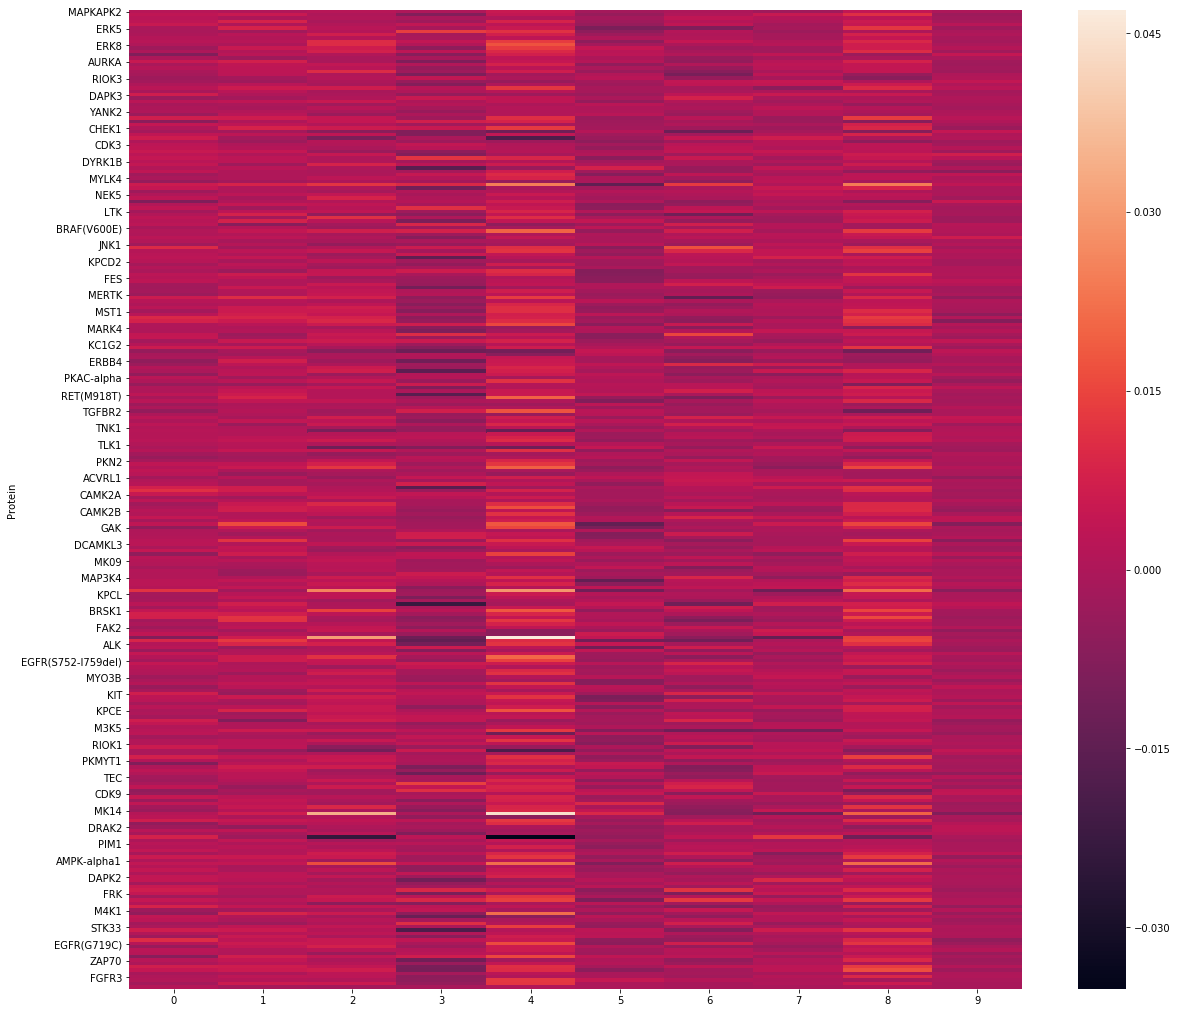

In [319]:
# Visualize the codes attributions on heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(drug_code_attributions_df, yticklabels=5)

plt.savefig("heatmap.pdf")
plt.show()

In [307]:
drug_data_df.tail()

Protein,MAPKAPK2,MARK1,CAMKK2,MARK2,TGFBR1,ERK5,EPHA7,MK01,RAF1,TNNI3K,...,KGP1,ZAP70,ERK3,BLK,MYLK2,KPCD3,FGFR3,ACVR1,GSK3A,KPCD
Small Molecule,,,,,,,,,,,,,,,,,,,,,
106,0.27367,0.578773,-1.277171,0.663306,0.53011,-2.077924,0.558570,0.504703,0.543965,0.703604,...,0.431771,0.558687,0.419640,0.909830,0.610636,-1.884795,0.669446,0.596209,0.585683,0.662448
1164,0.27367,0.578773,0.936437,0.663306,0.53011,-2.077924,0.558570,0.504703,0.543965,0.703604,...,0.431771,0.558687,0.419640,0.909830,0.610636,0.768343,0.669446,0.596209,0.585683,0.662448
1161,0.27367,-0.506518,-1.251129,-0.220159,0.53011,0.677499,0.558570,-0.310756,0.543965,0.703604,...,0.431771,0.007988,-3.576389,0.909830,-0.991743,0.600068,0.553375,-0.778958,-1.893409,0.662448
1050,0.27367,0.578773,0.441631,0.041609,0.53011,0.374402,0.032941,-0.488030,0.543965,0.515728,...,0.431771,0.558687,0.419640,-1.362892,0.610636,0.768343,-0.288138,0.596209,0.585683,0.662448
223,0.27367,0.578773,0.936437,0.663306,0.53011,0.677499,0.558570,0.504703,0.543965,0.703604,...,0.431771,0.558687,0.419640,0.909830,0.610636,0.768343,0.669446,0.596209,0.585683,0.662448


### Model sensitivity analysis

In [181]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [210]:
# Analyze whole rec system
def net(drug_input, cl_input):
    return model.network(drug_input, cl_input)[0]
model.network

RecSystemWithAutoencoders(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=241,

In [235]:
# Integrated Gradients
ig = IntegratedGradients(net)
# Establish samples on which to compute importances
k = 2   # How many samples use to compute importances
samples  = samples_train.copy()[:k]
cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()

cl_input.requires_grad_()
drug_input.requires_grad_()

attributions, delta = ig.attribute((drug_input, cl_input), return_convergence_delta=True)
drug_attributions, cl_attributions = attributions
drug_attributions = drug_attributions.detach().numpy()
cl_attributions = cl_attributions.detach().numpy()

print(drug_attributions.shape, drug_attributions.sum())
print(cl_attributions.shape, cl_attributions.sum())

drug_attributions = np.mean(drug_attributions, axis=0)
cl_attributions = np.mean(cl_attributions, axis=0)

print(drug_attributions.shape, drug_attributions.sum())
print(cl_attributions.shape, cl_attributions.sum())

drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]
# Sort by importance
drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

(2, 294) 0.38702577
(2, 241) 0.09732338
(294,) 0.19351289
(241,) 0.04866169


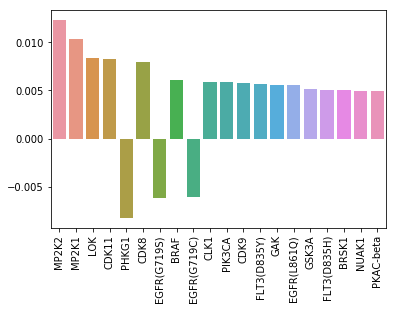

In [239]:
# Visualize k most important drug feats
k = 20
sns.barplot(x=[x[0] for x in drug_attributions[:k]], y=[x[1] for x in drug_attributions[:k]])
plt.xticks(rotation=90)
plt.show()

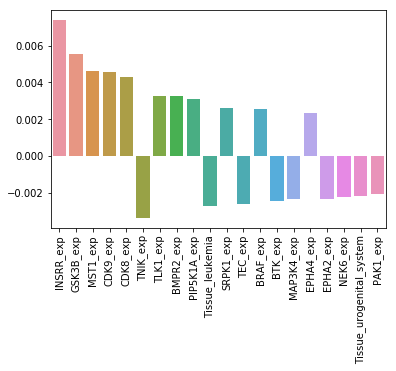

In [240]:
# Visualize k most important cl feats
k = 20
sns.barplot(x=[x[0] for x in cl_attributions[:k]], y=[x[1] for x in cl_attributions[:k]])
plt.xticks(rotation=90)
plt.show()

In [241]:
samples

,DRUG_ID,COSMIC_ID,AUC
80618,256,905940,0.546393
79722,255,905969,0.984562


## Train and evaluate new model with response variable transformation

#### Load dataset

In [3]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)
print(full_dataset.full_cell_lines_data.shape, full_dataset.drugs_data.shape)

Kinases Dataset + Remaning GDSC drug's putative targets <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset.
Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
nmutations in 18 genes.
In addition, expressions and mutations (17 new features) of remaining target genes from GDSC are included
Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered.
(922, 242) (74, 294)


#### Response variable transformation functions

In [44]:
def one_minus_log_transform(x):
    return - np.log(1 - x)

def one_minus_log_transform_inverse(x):
    return 1 - np.exp( - x)

def log_transform(x, base="exp"):
    if base == "exp":
        return  - np.log(x)
    elif base == 2:
        return np.log2(x)
def log_transform_inverse(x):
    return  np.exp( - x)

#### Data preprocessing

In [45]:
# Establish response data for samples (drug-cell line pairs)
response_df = full_dataset.response_data.copy()

# Transform the response variable
response_df["AUC"] = response_df["AUC"].map(log_transform)

# Establish cell line features data
cell_line_data_original_df = full_dataset.full_cell_lines_data.copy()

# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_original_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_original_df.index = cell_line_data_original_df.cell_line_id
cell_line_data_original_df = cell_line_data_original_df.drop("cell_line_id", axis=1)

# Extract response only for cell lines for which features are present
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]

# Establish drug features data
drug_data_original_df = full_dataset.drugs_data.copy()

# Convert drug index from LINCS name to GDSC drug ID
drug_data_original_df.index = drug_data_original_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)

# Establish how many cells go to train/val/test sets
num_val_cell_lines = 100
num_test_cell_lines = 100

print(drug_data_original_df.shape, cell_line_data_original_df.shape)

(74, 294) (922, 241)


In [46]:
response_df["AUC"].describe()

count    52730.000000
mean         0.226664
std          0.353382
min          0.000213
25%          0.033577
50%          0.103396
75%          0.273593
max          4.772997
Name: AUC, dtype: float64

In [49]:
a = 0.01
print(a)
a_trans = log_transform(a)
print(a_trans)
print(log_transform_inverse(a_trans))

0.01
4.605170185988091
0.010000000000000004


In [50]:
# Establish train, validation, and test sets
split_seed = 40   # ESTABLISH SPLIT SEED
# Split data into train/val/test sets
samples_train, samples_val, samples_test, cell_lines_test, cell_lines_val = Dataset.samples_train_test_split(
                                                                        response_df,
                                                                        num_val_cell_lines,
                                                                        num_test_cell_lines,
                                                                        split_seed,
                                                                        shuffle=True)
# Merge training and validation samples
samples_train_and_val = pd.concat([samples_train, samples_val], axis=0)
                                                                       
# Normalize the data
# Cell line data
cols_subset = [col for col in list(cell_line_data_original_df) if col.endswith("_exp")]
rows_subset = [x for x in cell_line_data_original_df.index if x not in cell_lines_test + cell_lines_val]

cell_line_data_df = Dataset.standardize_data(cell_line_data_original_df, cols_subset=cols_subset,
                                            rows_subset=rows_subset)
# Drug data
drug_data_df = Dataset.standardize_data(drug_data_original_df)

#### Instantiate the new system

In [137]:
# Setup seed for PyTorch models
torch.manual_seed(11)

In [138]:
state_dict = None

In [139]:
def establish_new_system(drug_dim, cell_line_dim, code_dim, architecture_type,
                    num_layers, drug_hidden_dim1, drug_hidden_dim2, drug_hidden_dim3,
                    cell_line_hidden_dim1, cell_line_hidden_dim2, cell_line_hidden_dim3,
                     dropout, dropout_rate, code_activation, activation_func, out_activation,
                        batch_norm):
    # Establish specs
    specs = {"drug_dim": drug_dim,
            "cell_line_dim": cell_line_dim,
            "code_dim": code_dim,
            "architecture_type": architecture_type,
            "num_layers": num_layers,
            "drug_hidden_dim1": drug_hidden_dim1,
            "drug_hidden_dim2": drug_hidden_dim2,
            "drug_hidden_dim3": drug_hidden_dim3,
            "cell_line_hidden_dim1": cell_line_hidden_dim1,
            "cell_line_hidden_dim2": cell_line_hidden_dim2,
            "cell_line_hidden_dim3": cell_line_hidden_dim3,
            "dropout": dropout,
            "dropout_rate": dropout_rate,
            "code_activation": code_activation,
            "activation_func": activation_func,
            "out_activation": out_activation,
            "batch_norm": batch_norm}
    
    network = ModelAnalysis.instantiate_system(specs, state_dict)
    return network

establish_new_system_widget = interactive(establish_new_system,
                                     drug_dim=[294],
                                     cell_line_dim=[241, 1144],
                                     code_dim=widgets.IntSlider(value=10, min=2, max=30),
                                     architecture_type=["autoencoders", "linear"],
                                     num_layers=[1, 2, 3, None],
                                     drug_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     drug_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     drug_hidden_dim3=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim3=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     dropout=[False, True],
                                     dropout_rate=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05),
                                     code_activation=[False, True],
                                     activation_func=[nn.ReLU, nn.Tanh, nn.SELU],
                                     out_activation=[torch.sigmoid, None],
                                     batch_norm=[False, True])
display(establish_new_system_widget)

interactive(children=(Dropdown(description='drug_dim', options=(294,), value=294), Dropdown(description='cell_…

In [140]:
# MUST EXECUTE ALSO
network = establish_new_system_widget.result
network

RecSystemWithAutoencoders(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=128, out_features=241,

In [141]:
print(network.out_activation)
print(next(network.parameters()).sum())

None
tensor(-0.6877, grad_fn=<SumBackward0>)


In [142]:
# Training params
num_epochs = 200
batch_size = 512
no_batches = samples_train.shape[0] // batch_size + 1
# Establish the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.00001
reconstruction_term_drug = 0.05
reconstruction_term_cl = 0.1
independence_term_drug = 0.2
independence_term_cl = 0.2
reg_lambda = 0.00

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(no_batches, device)

81 cpu


#### Train with early stopping

In [143]:
early_stopping = EarlyStopping(patience=10, delta=0.000)

In [144]:
model = ModelWithAutoencoders("Test", network)
train_losses = []
drug_independence_train_losses = []
cl_independence_train_losses = []
train_rmses = []
train_corrs = []
train_median_corrs = []
train_drug_rec_corrs = []
train_cl_rec_corrs = []
val_rmses = []
val_corrs = []
val_median_corrs = []
val_drug_rec_corrs = []
val_cl_rec_corrs = []

for epoch in range(1, num_epochs + 1):
    loss, drug_recounstruction_loss, cl_reconstruction_loss, drug_independence_loss, cl_independence_loss = model.train_with_independence_penalty(
    samples_train, cell_line_data_df, drug_data_df, batch_size, optimizer, criterion, reconstruction_term_drug,
    reconstruction_term_cl, independence_term_drug, independence_term_cl, reg_lambda)
    print("Epoch: {}, loss: {}, drug independence loss: {}, cell line independence loss: {}".format(
        epoch, loss, drug_independence_loss, cl_independence_loss))
    
    train_losses.append(loss.item())
    drug_independence_train_losses.append(drug_independence_loss.item())
    cl_independence_train_losses.append(cl_independence_loss.item())
    
    # Evaluate on training data
    predicted, y_true, drug_input, cl_input = model.predict(samples_train, cell_line_data_df, drug_data_df)
    preds, drug_reconstruction, cl_reconstruction = predicted
    t0 = time.time()
    try:
        train_rmse, train_corr = Model.evaluate_predictions(y_true, preds.cpu().numpy().reshape(-1))
    except ValueError:
        train_rmse, train_corr = np.nan, (np.nan, np.nan)
    # Drug reconstruction training error
    try:
        train_drug_rec_rmse, train_drug_rec_corr = Model.evaluate_predictions(drug_input.flatten(),
                                        drug_reconstruction.cpu().numpy().flatten())
    except ValueError:
        train_drug_rec_rmse, train_drug_rec_corr = np.nan, (np.nan, np.nan)

    # Cell line reconstruction training error
    try:
        train_cl_rec_rmse, train_cl_rec_corr = Model.evaluate_predictions(cl_input.flatten(),
                                        cl_reconstruction.cpu().numpy().flatten())
    except ValueError:
        train_cl_rec_rmse, train_cl_rec_corr = np.nan, (np.nan, np.nan)

    performance_df = Model.per_drug_performance_df(samples_train, preds.cpu())
    train_median_rmse = performance_df["Model RMSE"].median()
    train_median_corr = performance_df["Model correlation"].median()
    
    train_rmses.append(train_rmse)
    train_corrs.append(train_corr[0])
    train_median_corrs.append(train_median_corr)
    train_drug_rec_corrs.append(train_drug_rec_corr[0])
    train_cl_rec_corrs.append(train_cl_rec_corr[0])
    
    # Evaluate on validation data
    predicted, y_true, drug_input, cl_input = model.predict(samples_val, cell_line_data_df, drug_data_df)
    preds, drug_reconstruction, cl_reconstruction = predicted
    
    # Main validation error
    try:
        val_rmse, val_corr = Model.evaluate_predictions(y_true, preds.cpu().numpy().reshape(-1))
    except ValueError:
        val_rmse, val_corr = np.nan, (np.nan, np.nan)

    # Drug reconstruction validation error
    try:
        val_drug_rec_rmse, val_drug_rec_corr = Model.evaluate_predictions(drug_input.flatten(),
                                        drug_reconstruction.cpu().numpy().flatten())
    except ValueError:
        val_drug_rec_rmse, val_drug_rec_corr = np.nan, (np.nan, np.nan)

    # Cell line reconstruction validation error
    try:
        val_cl_rec_rmse, val_cl_rec_corr = Model.evaluate_predictions(cl_input.flatten(),
                                        cl_reconstruction.cpu().numpy().flatten())
    except ValueError:
        val_cl_rec_rmse, val_cl_rec_corr = np.nan, (np.nan, np.nan)
    # Per-drug validation evaluation
    performance_df = Model.per_drug_performance_df(samples_val, preds.cpu())
    val_median_corr = performance_df["Model correlation"].median()
        
    val_rmses.append(val_rmse)
    val_corrs.append(val_corr[0])
    val_drug_rec_corrs.append(val_drug_rec_corr[0])
    val_cl_rec_corrs.append(val_cl_rec_corr[0])
    val_median_corrs.append(val_median_corr)
    
    early_stopping(val_rmse, model.network)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break

cpu
Epoch: 1, loss: 0.4274064600467682, drug independence loss: 0.014374323189258575, cell line independence loss: 0.005541488528251648


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


cpu
Epoch: 2, loss: 0.38640421628952026, drug independence loss: 0.01082804799079895, cell line independence loss: 0.009131424129009247
cpu
Epoch: 3, loss: 0.387982577085495, drug independence loss: 0.012118980288505554, cell line independence loss: 0.008303962647914886
cpu
Epoch: 4, loss: 0.3985084891319275, drug independence loss: 0.007015995681285858, cell line independence loss: 0.008429214358329773
cpu
Epoch: 5, loss: 0.32366693019866943, drug independence loss: 0.005142323672771454, cell line independence loss: 0.005530305206775665
cpu
Epoch: 6, loss: 0.3105820119380951, drug independence loss: 0.0063915736973285675, cell line independence loss: 0.006274331361055374
cpu
Epoch: 7, loss: 0.3287540376186371, drug independence loss: 0.004448443651199341, cell line independence loss: 0.006237950176000595
cpu
Epoch: 8, loss: 0.32816219329833984, drug independence loss: 0.0045595597475767136, cell line independence loss: 0.005068372935056686
cpu
Epoch: 9, loss: 0.3082037568092346, drug 

In [155]:
def learning_curve(metric1, metric2):
    """Plot learning curve related to a given metric."""
    dic = {"Training loss": train_losses,
          "Drug independence train loss": drug_independence_train_losses,
          "Cl independence train loss": cl_independence_train_losses,
           "Train RMSE": train_rmses,
           "Train corr.": train_corrs,
           "Train median corr.": train_median_corrs,
           "Train drug rec corr.": train_drug_rec_corrs,
           "Train cl rec corr.": train_cl_rec_corrs,
          "Val RMSE": val_rmses,
          "Val corr.": val_corrs,
          "Val median corr.": val_median_corrs,
          "Val drug rec corr.": val_drug_rec_corrs,
          "Val cl rec corr.": val_cl_rec_corrs}
    
    x = range(1, len(train_losses) + 1)
    print("Max {}: {}".format(metric1, max(dic[metric1])))
    sns.lineplot(x, dic[metric1], label=metric1)
    if metric2:
        print("Max {}: {}".format(metric2, max(dic[metric2])))
        sns.lineplot(x, dic[metric2], label=metric2)
    
    plt.show()
    
metrics = ["Training loss", "Drug independence train loss", "Cl independence train loss",
           "Train RMSE", "Train corr.", "Train median corr.", "Train drug rec corr.", "Train cl rec corr.",
          "Val RMSE", "Val corr.", "Val median corr.", "Val drug rec corr.", "Val cl rec corr."]

interact(learning_curve,
        metric1=metrics,
        metric2=[None] + metrics)

interactive(children=(Dropdown(description='metric1', options=('Training loss', 'Drug independence train loss'…

<function __main__.learning_curve(metric1, metric2)>

### Evaluate response predictions

In [156]:
# Evaluation on training set
samples = samples_train.copy()
print("Training data")
print()
# Make predictions
# Linear model case
if model.__class__ == Model:
    response_preds, y_true = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    print(response_preds.shape, y_true.shape)
# Model with autoencoders case
elif model.__class__ == ModelWithAutoencoders:
    predicted, y_true, drug_input, cl_input = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    response_preds, drug_rec_preds, cl_rec_preds = predicted
    print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_train_df = samples.copy()
samples_with_predictions_train_df.insert(3, "Predicted AUC", response_preds.reshape(-1))
print(samples_with_predictions_train_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.numpy().reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

per_drug_performance_train_df = Model.per_drug_performance_df(samples, response_preds)
print(per_drug_performance_train_df.shape)
per_drug_performance_train_df.insert(1, "Drug name", per_drug_performance_train_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_train_df.shape)
per_drug_performance_train_df = per_drug_performance_train_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_train_df["Model RMSE"].median(),
     per_drug_performance_train_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.numpy().ravel())
print("Reconstruction performance:")
print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.numpy().ravel())
print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_train_df.head(2)

Training data

torch.Size([41130, 1]) (41130,) (41130, 294) (41130, 241)
(41130, 4)
Response prediction performance:
RMSE: 0.2118131472432028, Corr.: (0.8112741152060683, 0.0)


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(74, 6)
(74, 7)
Per drug median RMSE and correlation: 0.14025427265944865 0.40864310154563377

Reconstruction performance:
Whole drug data RMSE and correlation: 0.758 (0.6467443679390027, 0.0)
Whole cell line data RMSE and correlation: 0.825 (0.46308065305414153, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
14,371,Torin 2,0.560409,0.839937,0.904143,NaN,641
37,317,WYE-125132,0.480959,0.765997,0.677451,NaN,669


In [157]:
# Evaluation on validation set
samples = samples_val.copy()
print("Validation data")
print()
# Make predictions
# Linear model case
if model.__class__ == Model:
    response_preds, y_true = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    print(response_preds.shape, y_true.shape)
# Model with autoencoders case
elif model.__class__ == ModelWithAutoencoders:
    predicted, y_true, drug_input, cl_input = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    response_preds, drug_rec_preds, cl_rec_preds = predicted
    print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_val_df = samples.copy()
samples_with_predictions_val_df.insert(3, "Predicted AUC", response_preds.reshape(-1))
print(samples_with_predictions_val_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.numpy().reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

per_drug_performance_val_df = Model.per_drug_performance_df(samples, response_preds)
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df.insert(1, "Drug name", per_drug_performance_val_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df = per_drug_performance_val_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_val_df["Model RMSE"].median(),
     per_drug_performance_val_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.numpy().ravel())
print("Reconstruction performance:")
print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.numpy().ravel())
print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_train_df.head(2)

Validation data

torch.Size([5840, 1]) (5840,) (5840, 294) (5840, 241)
(5840, 4)
Response prediction performance:
RMSE: 0.2566126039307583, Corr.: (0.7135919850639084, 0.0)


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(74, 6)
(74, 7)
Per drug median RMSE and correlation: 0.16833154242636153 0.30410762102657984

Reconstruction performance:
Whole drug data RMSE and correlation: 0.761 (0.645056751803021, 0.0)
Whole cell line data RMSE and correlation: 0.881 (0.4291548539373026, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
14,371,Torin 2,0.560409,0.839937,0.904143,NaN,641
37,317,WYE-125132,0.480959,0.765997,0.677451,NaN,669


In [158]:
# Evaluation on training set in the original response variable (AUC)
samples = samples_train.copy()
print("Training data")
print()
# Make predictions
# Linear model case
if model.__class__ == Model:
    response_preds, y_true = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    print(response_preds.shape, y_true.shape)
# Model with autoencoders case
elif model.__class__ == ModelWithAutoencoders:
    predicted, y_true, drug_input, cl_input = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    response_preds, drug_rec_preds, cl_rec_preds = predicted
    print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)
    
# Go back to orginal AUC
response_preds = torch.from_numpy(log_transform_inverse(response_preds.detach().numpy()))
y_true = log_transform_inverse(y_true)
samples["AUC"] = samples["AUC"].map(log_transform_inverse)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_train_df = samples.copy()
samples_with_predictions_train_df.insert(3, "Predicted AUC", response_preds.reshape(-1))
print(samples_with_predictions_train_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.numpy().reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

per_drug_performance_train_df = Model.per_drug_performance_df(samples, response_preds)
print(per_drug_performance_train_df.shape)
per_drug_performance_train_df.insert(1, "Drug name", per_drug_performance_train_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_train_df.shape)
per_drug_performance_train_df = per_drug_performance_train_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_train_df["Model RMSE"].median(),
     per_drug_performance_train_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.numpy().ravel())
print("Reconstruction performance:")
print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.numpy().ravel())
print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_train_df.head(2)

Training data

torch.Size([41130, 1]) (41130,) (41130, 294) (41130, 241)
(41130, 4)
Response prediction performance:
RMSE: 0.11184566851125544, Corr.: (0.797014869633551, 0.0)


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(74, 6)
(74, 7)
Per drug median RMSE and correlation: 0.10258923448904797 0.4080185594464194

Reconstruction performance:
Whole drug data RMSE and correlation: 0.758 (0.6467443679390027, 0.0)
Whole cell line data RMSE and correlation: 0.825 (0.46308065305414153, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
14,371,Torin 2,0.176622,0.764199,0.240905,NaN,641
39,374,GSK1059615,0.144006,0.745053,0.203644,NaN,668


In [163]:
samples_with_predictions_train_df["Predicted AUC"].min()

0.037863318

In [166]:
# Evaluation on validation set in the original response variable (AUC)
samples = samples_val.copy()
print("Validation data")
print()
# Make predictions
# Linear model case
if model.__class__ == Model:
    response_preds, y_true = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    print(response_preds.shape, y_true.shape)
# Model with autoencoders case
elif model.__class__ == ModelWithAutoencoders:
    predicted, y_true, drug_input, cl_input = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    response_preds, drug_rec_preds, cl_rec_preds = predicted
    print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)
    
# Go back to orginal AUC
response_preds = torch.from_numpy(log_transform_inverse(response_preds.detach().numpy()))
y_true = log_transform_inverse(y_true)
samples["AUC"] = samples["AUC"].map(log_transform_inverse)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_val_df = samples.copy()
samples_with_predictions_val_df.insert(3, "Predicted AUC", response_preds.reshape(-1))
print(samples_with_predictions_val_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

per_drug_performance_val_df = Model.per_drug_performance_df(samples, response_preds)
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df.insert(1, "Drug name", per_drug_performance_val_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df = per_drug_performance_val_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_val_df["Model RMSE"].median(),
     per_drug_performance_val_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.numpy().ravel())
print("Reconstruction performance:")
print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.numpy().ravel())
print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_val_df.head(2)

Validation data

torch.Size([5840, 1]) (5840,) (5840, 294) (5840, 241)
(5840, 4)
Response prediction performance:
RMSE: 0.12989543381576074, Corr.: (0.7312774835060774, 0.0)


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(74, 6)
(74, 7)
Per drug median RMSE and correlation: 0.1152101840417539 0.30325856863541234

Reconstruction performance:
Whole drug data RMSE and correlation: 0.761 (0.645056751803021, 0.0)
Whole cell line data RMSE and correlation: 0.881 (0.4291548539373026, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
30,257,NPK76-II-72-1,0.129814,0.741021,0.176002,NaN,92
61,222,BX-912,0.151640,0.701706,0.207612,NaN,91


In [171]:
per_drug_performance_val_df.head(20)

,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
30,257,NPK76-II-72-1,0.129814,0.741021,0.176002,NaN,92
61,222,BX-912,0.151640,0.701706,0.207612,NaN,91
48,260,NG-25,0.136860,0.689696,0.181852,NaN,92
20,256,JW-7-24-1,0.132649,0.618700,0.168235,NaN,93
8,1085,Sorafenib,0.099533,0.600233,0.123044,NaN,80
33,252,WZ3105,0.147192,0.588700,0.175847,NaN,93
23,330,XMD13-2,0.084605,0.588519,0.103441,NaN,93
22,301,PHA-793887,0.197199,0.583939,0.237997,NaN,93
59,1373,Dabrafenib,0.162164,0.564938,0.165971,NaN,92
69,329,QL-XI-92,0.082432,0.533488,0.096833,NaN,93
